In [1]:
from __future__ import print_function, division
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

from Transform import *
from test import Rescale,RandomCrop

import tensorflow as tf
from tensorflow.data import Dataset

tf.enable_eager_execution()

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


In [2]:
csv_file_path='data/faces/face_landmarks2.csv'
root_dir='data/faces/'

In [3]:
def show_landmarks(image, landmarks):
    """Show image with landmarks"""
    image = image.astype(int)

    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated


In [4]:
def createFaceLandmarksDataset(csv_file, root_dir,type="cpp"):
    """Face Landmarks dataset."""
    if type == "cpp":
        rescale = Rescale(256)
        crop = RandomCrop(224)
    else:
        rescale = PyRescale(256)
        crop = PyRandomCrop(224)

        
    landmarks_frame = pd.read_csv(csv_file)
    
    images = []
    landmarks = []

    for idx in range(landmarks_frame.shape[0]):
        T1 = time.time()
        landmark = landmarks_frame.iloc[idx, 1:]
        landmark = np.array([landmark]).reshape(-1, 2).astype('float64')

        T2 = time.time()
        img_name = os.path.join(root_dir, landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        
        T31 = time.time()
        image, landmark = rescale(image, landmark)
        T32 = time.time()
        image, landmark = crop(image, landmark)
        T4 = time.time()

        images.append(image)
        landmarks.append(landmark)

        T5 = time.time()
        
        
        #print(T32-T31,T4-T32)
    images = np.array(images)
    landmarks = np.array(landmarks)

    return tf.data.Dataset.from_tensor_slices((images, landmarks))


In [5]:
#Load dataset
for i in range(1):
    start_time = time.time()
    train_dataset = createFaceLandmarksDataset(csv_file=csv_file_path,root_dir=root_dir,type="python").batch(32)
    end_time = time.time()
    
    print("Python Load time: ",end_time - start_time)

    start_time = time.time()
    train_dataset = createFaceLandmarksDataset(csv_file=csv_file_path,root_dir=root_dir,type="cpp").batch(32)
    end_time = time.time()

    print("C++ Load time: ",end_time - start_time)


Python Load time:  18.74070715904236
C++ Load time:  27.741607904434204


(32, 224, 224, 3)


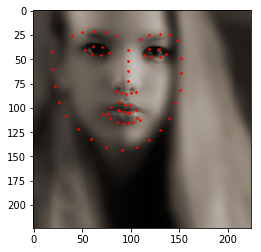

In [6]:
#Test data
i,l = next(iter(train_dataset))
print(i.shape)
i = i.numpy().astype(int)[0]
l = l.numpy()[0]

show_landmarks(i,l)



In [7]:
# Pre-trained model with MobileNetV2
base_model = tf.keras.applications.vgg16.VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the pre-trained model weights
base_model.trainable = False

# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(136)
reshape_layer = tf.keras.layers.Reshape((68, 2), input_shape=(136,))

# Layer classification head with feature detector
model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer,
    reshape_layer
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.05), 
              loss='mean_squared_error',
              metrics=['mse']
)


In [ ]:
# Train model
start_time = time.time()

hist = model.fit(train_dataset,epochs=500)

results = model.evaluate(train_dataset)

end_time = time.time()

train_model_time = end_time - start_time



Epoch 1/500
44/44 [==============================] - 6s 146ms/step - loss: 37397.4402 - mean_squared_error: 38087.4336
Epoch 2/500
44/44 [==============================] - 4s 89ms/step - loss: 1606.9462 - mean_squared_error: 1603.4103
Epoch 3/500
44/44 [==============================] - 4s 89ms/step - loss: 942.0581 - mean_squared_error: 940.0730
Epoch 4/500
44/44 [==============================] - 4s 89ms/step - loss: 733.9579 - mean_squared_error: 732.2205
Epoch 5/500
44/44 [==============================] - 4s 88ms/step - loss: 627.3526 - mean_squared_error: 625.8175
Epoch 6/500
44/44 [==============================] - 4s 89ms/step - loss: 575.4503 - mean_squared_error: 574.0118
Epoch 7/500
44/44 [==============================] - 4s 89ms/step - loss: 538.1266 - mean_squared_error: 536.7581
Epoch 8/500
44/44 [==============================] - 4s 91ms/step - loss: 506.6368 - mean_squared_error: 505.3454
Epoch 9/500
44/44 [==============================] - 4s 88ms/step - loss: 484.114

44/44 [==============================] - 4s 88ms/step - loss: 3965.8847 - mean_squared_error: 3957.9812
Epoch 65/500
44/44 [==============================] - 4s 88ms/step - loss: 3536.7880 - mean_squared_error: 3531.3357
Epoch 66/500
44/44 [==============================] - 4s 89ms/step - loss: 3372.9295 - mean_squared_error: 3367.4712
Epoch 67/500
44/44 [==============================] - 4s 89ms/step - loss: 3208.2008 - mean_squared_error: 3202.3022
Epoch 68/500
44/44 [==============================] - 4s 89ms/step - loss: 2953.7558 - mean_squared_error: 2948.2456
Epoch 69/500
44/44 [==============================] - 4s 89ms/step - loss: 3066.1887 - mean_squared_error: 3061.6011
Epoch 70/500
44/44 [==============================] - 4s 88ms/step - loss: 2298.7208 - mean_squared_error: 2293.8308
Epoch 71/500
44/44 [==============================] - 4s 88ms/step - loss: 2377.3601 - mean_squared_error: 2373.5718
Epoch 72/500
44/44 [==============================] - 4s 89ms/step - loss: 25

44/44 [==============================] - 4s 90ms/step - loss: 5530.8046 - mean_squared_error: 5521.2622
Epoch 134/500
44/44 [==============================] - 4s 88ms/step - loss: 4819.0664 - mean_squared_error: 4811.3721
Epoch 135/500
44/44 [==============================] - 4s 89ms/step - loss: 4953.8004 - mean_squared_error: 4947.7666
Epoch 136/500
44/44 [==============================] - 4s 89ms/step - loss: 4412.5193 - mean_squared_error: 4406.4702
Epoch 137/500
44/44 [==============================] - 4s 88ms/step - loss: 4439.6976 - mean_squared_error: 4432.1240
Epoch 138/500
44/44 [==============================] - 4s 89ms/step - loss: 4760.2755 - mean_squared_error: 4754.1904
Epoch 139/500
44/44 [==============================] - 4s 88ms/step - loss: 5308.1536 - mean_squared_error: 5301.1328
Epoch 140/500
44/44 [==============================] - 4s 89ms/step - loss: 4435.7014 - mean_squared_error: 4430.5771
Epoch 141/500
44/44 [==============================] - 4s 88ms/step - 

44/44 [==============================] - 4s 88ms/step - loss: 3382.7391 - mean_squared_error: 3379.2319
Epoch 203/500
44/44 [==============================] - 4s 91ms/step - loss: 4811.8611 - mean_squared_error: 4805.6787
Epoch 204/500
44/44 [==============================] - 4s 90ms/step - loss: 5887.7059 - mean_squared_error: 5880.9062
Epoch 205/500
44/44 [==============================] - 4s 89ms/step - loss: 5185.4409 - mean_squared_error: 5181.5166
Epoch 206/500
44/44 [==============================] - 4s 88ms/step - loss: 5807.8998 - mean_squared_error: 5798.7827
Epoch 207/500
44/44 [==============================] - 4s 90ms/step - loss: 4077.3413 - mean_squared_error: 4071.2659
Epoch 208/500
44/44 [==============================] - 4s 90ms/step - loss: 4606.4366 - mean_squared_error: 4597.7778
Epoch 209/500
44/44 [==============================] - 4s 90ms/step - loss: 4061.6589 - mean_squared_error: 4056.0264
Epoch 210/500
44/44 [==============================] - 4s 90ms/step - 

44/44 [==============================] - 4s 88ms/step - loss: 3483.1141 - mean_squared_error: 3478.0635
Epoch 272/500
44/44 [==============================] - 4s 89ms/step - loss: 4032.6773 - mean_squared_error: 4025.1709
Epoch 273/500
44/44 [==============================] - 4s 90ms/step - loss: 3567.6612 - mean_squared_error: 3561.8748
Epoch 274/500
44/44 [==============================] - 4s 90ms/step - loss: 3856.1314 - mean_squared_error: 3850.0120
Epoch 275/500
44/44 [==============================] - 4s 91ms/step - loss: 3376.2114 - mean_squared_error: 3372.6851
Epoch 276/500
44/44 [==============================] - 4s 89ms/step - loss: 5117.1252 - mean_squared_error: 5108.4980
Epoch 277/500
44/44 [==============================] - 4s 88ms/step - loss: 4689.3497 - mean_squared_error: 4681.5093
Epoch 278/500
44/44 [==============================] - 4s 88ms/step - loss: 3630.9755 - mean_squared_error: 3625.7917
Epoch 279/500
44/44 [==============================] - 4s 88ms/step - 

In [ ]:
image, landmark = next(iter(train_dataset))
for key in range(5):
    show_landmarks(image.numpy()[key],model.predict(image)[key])
    show_landmarks(image.numpy()[key],landmark[key].numpy())